Python Version 3.10.13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import StringIO

In [2]:

base_path = '../data/CAF_Sensor_Dataset_2/caf_sensors'
daily_path = os.path.join(base_path, 'Daily')
hourly_path = os.path.join(base_path, 'Hourly')
bulk_density_path = '../data/CAF_Sensor_Dataset_2/CAF_BulkDensity.txt'
particle_size_path = '../data/CAF_Sensor_Dataset_2/CAF_ParticleSize.txt'

In [3]:
#load sensor data 
def load_sensor_data(folder_path):
    data_frames = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, delim_whitespace=True)
            df['Location'] = file_name.split('.')[0]
            data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)


In [4]:
# Load daily and hourly data
daily_data = load_sensor_data(daily_path)
hourly_data = load_sensor_data(hourly_path)

bulk_density_data = pd.read_csv(bulk_density_path, delim_whitespace=True)
particle_size_data = pd.read_csv(particle_size_path, delim_whitespace=True)

In [5]:

# Display basic information
print("Daily Data Info:")
daily_data.info()
print("\nHourly Data Info:")
hourly_data.info()
print("\nBulk Density Data Info:")
bulk_density_data.info()
print("\nParticle Size Data Info:")
particle_size_data.info()
#daily around 50% null, 

Daily Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140532 entries, 0 to 140531
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Location  140532 non-null  object 
 1   Date      140532 non-null  object 
 2   VW_30cm   77571 non-null   float64
 3   VW_60cm   75188 non-null   float64
 4   VW_90cm   75525 non-null   float64
 5   VW_120cm  75785 non-null   float64
 6   VW_150cm  74521 non-null   float64
 7   T_30cm    77954 non-null   float64
 8   T_60cm    76662 non-null   float64
 9   T_90cm    76750 non-null   float64
 10  T_120cm   76556 non-null   float64
 11  T_150cm   73403 non-null   float64
dtypes: float64(10), object(2)
memory usage: 12.9+ MB

Hourly Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373658 entries, 0 to 3373657
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Location  object 
 1   Date      object 
 2   Time      object 
 3   VW_30c

In [6]:

print("\nDaily Data Summary:")
daily_data.describe()
print("\nHourly Data Summary:")
hourly_data.describe()
print("\nBulk Density Data Summary:")
bulk_density_data.describe()
print("\nParticle Size Data Summary:")
particle_size_data.describe()



Daily Data Summary:

Hourly Data Summary:

Bulk Density Data Summary:

Particle Size Data Summary:


,Depth,Silt,Clay,Sand
count,210.000000,209.000000,209.000000,209.000000
mean,90.000000,59.217191,27.988455,12.794134
std,42.527784,5.616284,5.968292,2.680723
min,30.000000,41.851000,12.105000,6.837000
25%,60.000000,56.312000,24.555000,11.213000
50%,90.000000,59.873000,27.529000,12.514000
75%,120.000000,62.726000,30.950000,14.114000
max,150.000000,75.281000,45.779000,25.132000


In [7]:

# checking missing values
daily_data_null_info = daily_data.isna().sum()
print(f"\nDaily data null info:\n{daily_data_null_info}")
hourly_data_null_info = hourly_data.isnull().sum()
print(f"\nhourly data null info:\n{hourly_data_null_info}")
bulk_density_data_null_info = bulk_density_data.isnull().sum()
print(f"\nbulk density data null info:\n{bulk_density_data_null_info}")
particle_size_data_null_info = particle_size_data.isnull().sum()
print(f"\nParitcle data null info:\n{particle_size_data_null_info}")


Daily data null info:
Location        0
Date            0
VW_30cm     62961
VW_60cm     65344
VW_90cm     65007
VW_120cm    64747
VW_150cm    66011
T_30cm      62578
T_60cm      63870
T_90cm      63782
T_120cm     63976
T_150cm     67129
dtype: int64

hourly data null info:
Location          0
Date            890
Time            890
VW_30cm     1531380
VW_60cm     1569639
VW_90cm     1579300
VW_120cm    1571883
VW_150cm    1596537
T_30cm      1521976
T_60cm      1549976
T_90cm      1549457
T_120cm     1552851
T_150cm     1623785
dtype: int64

bulk density data null info:
Location       0
Depth          0
BulkDensity    0
dtype: int64

Paritcle data null info:
Location    0
Depth       0
Silt        1
Clay        1
Sand        1
dtype: int64


In [8]:
#converting string date of daily data to datetime
daily_data['Date'] = pd.to_datetime(daily_data['Date'], format='%m/%d/%Y')

In [11]:
from functools import reduce

qc_folder_path = '../data/CAF_Sensor_Dataset_2/QC/Flags'

def load_qc_flags(folder_path, prefix):
    qc_flags = []
    for file_name in os.listdir(folder_path):
        if file_name.startswith(prefix):
            sensor_depth = file_name.split('_')[1].split('.')[0]
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, delim_whitespace=True, skipinitialspace=True)
            
            if df.shape[0] == 0:
                print(f"Skipping empty file: {file_name}")
                continue

            df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
            flag_column = f'Flag_{prefix}_{sensor_depth}cm'
            df.rename(columns={df.columns[2]: flag_column}, inplace=True)
            df['SensorDepth'] = sensor_depth
            qc_flags.append(df[['Location', 'Date', flag_column]])
    return qc_flags

# Load all QC flags
missing_flags = load_qc_flags(qc_folder_path, 'missing')
range_flags = load_qc_flags(qc_folder_path, 'range')
flats_flags = load_qc_flags(qc_folder_path, 'flats')
spikes_flags = load_qc_flags(qc_folder_path, 'spikes')
breaks_flags = load_qc_flags(qc_folder_path, 'breaks')

# Combine all QC flags into a single list
all_flags = missing_flags + range_flags + flats_flags + spikes_flags + breaks_flags


Skipping empty file: rangeT_60.txt
Skipping empty file: rangeT_120.txt
Skipping empty file: rangeT_90.txt
Skipping empty file: rangeT_150.txt
Skipping empty file: flatsT_60.txt
Skipping empty file: flatsT_30.txt
Skipping empty file: flatsT_120.txt
Skipping empty file: flatsT_90.txt
Skipping empty file: flatsT_150.txt
Skipping empty file: breaksVW_90.txt
Skipping empty file: breaksVW_30.txt
Skipping empty file: breaksVW_150.txt
Skipping empty file: breaksVW_120.txt
Skipping empty file: breaksVW_60.txt


In [30]:
missing_flags.items()

dict_items([('missing', [      Location       Date VW_30cm SensorDepth
0       CAF003 2007-04-20       M          30
1       CAF003 2007-04-21       M          30
2       CAF003 2007-04-22       M          30
3       CAF003 2007-04-23       M          30
4       CAF003 2007-04-24       M          30
...        ...        ...     ...         ...
62956   CAF401 2012-11-04       M          30
62957   CAF401 2012-11-05       M          30
62958   CAF401 2014-04-11       M          30
62959   CAF401 2014-04-12       M          30
62960   CAF401 2014-04-13       M          30

[62961 rows x 4 columns],       Location       Date T_60cm SensorDepth
0       CAF003 2007-04-20      M          60
1       CAF003 2007-04-21      M          60
2       CAF003 2007-04-22      M          60
3       CAF003 2007-04-23      M          60
4       CAF003 2007-04-24      M          60
...        ...        ...    ...         ...
63865   CAF401 2016-06-12      M          60
63866   CAF401 2016-06-13      M    

In [12]:
def merge_all_flags(sensor_data, flags_list):
    # Use reduce to merge all DataFrames in the list
    merged_flags = reduce(lambda left, right: pd.merge(left, right, on=['Location', 'Date'], how='left'), flags_list)
    # Merge the resulting flags DataFrame with the sensor data
    sensor_data = pd.merge(sensor_data, merged_flags, on=['Location', 'Date'], how='left')
    return sensor_data


In [13]:

# Merge all QC flags with daily data
daily_data = merge_all_flags(daily_data, all_flags)


: 

In [ ]:

# merge all QC flags with hourly data
hourly_data = merge_all_flags(hourly_data, all_flags)


In [22]:
def handle_qc_issues(data):
    # Replace missing values (flagged as 'M') with NaN
    for col in data.columns:
        if col.startswith('Flag_missing'):
            depth = col.split('_')[2].replace('cm', '')
            vw_col = f'VW_{depth}cm'
            data.loc[data[col] == 'M', vw_col] = float('nan')
    
    # Remove rows with outliers (flagged as 'C' or 'D')
    for col in data.columns:
        if col.startswith('Flag_range') or col.startswith('Flag_flats') or col.startswith('Flag_spikes') or col.startswith('Flag_breaks'):
            data = data[~data[col].isin(['C', 'D'])]

    return data

# Handle QC issues in daily and hourly data
daily_data_cleaned = handle_qc_issues(daily_data)
hourly_data_cleaned = handle_qc_issues(hourly_data)

In [ ]:
daily_data.head(40)

In [9]:

# volumetric water content (VW) at different depths
def plot_vw_at_depth(data, depth):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y=f'VW_{depth}cm', hue='Location', data=data)
    plt.title(f'Volumetric Water Content at {depth}cm Depth Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'VW_{depth}cm (m^3/m^3)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()


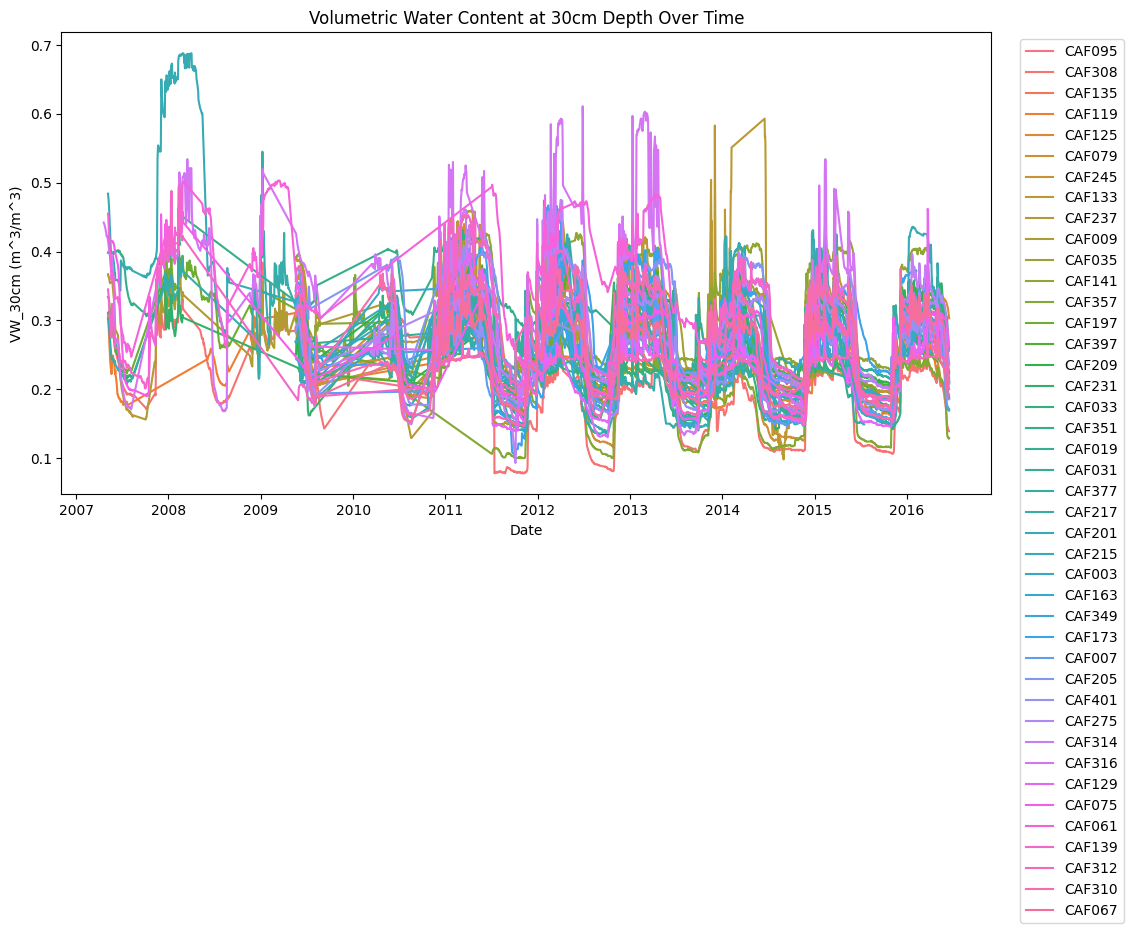

In [11]:
plot_vw_at_depth(daily_data, 30)

In [10]:

# temperature (T) at different depths
def plot_temp_at_depth(data, depth):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y=f'T_{depth}cm', hue='Location', data=data)
    plt.title(f'Soil Temperature at {depth}cm Depth Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'T_{depth}cm (°C)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.show()



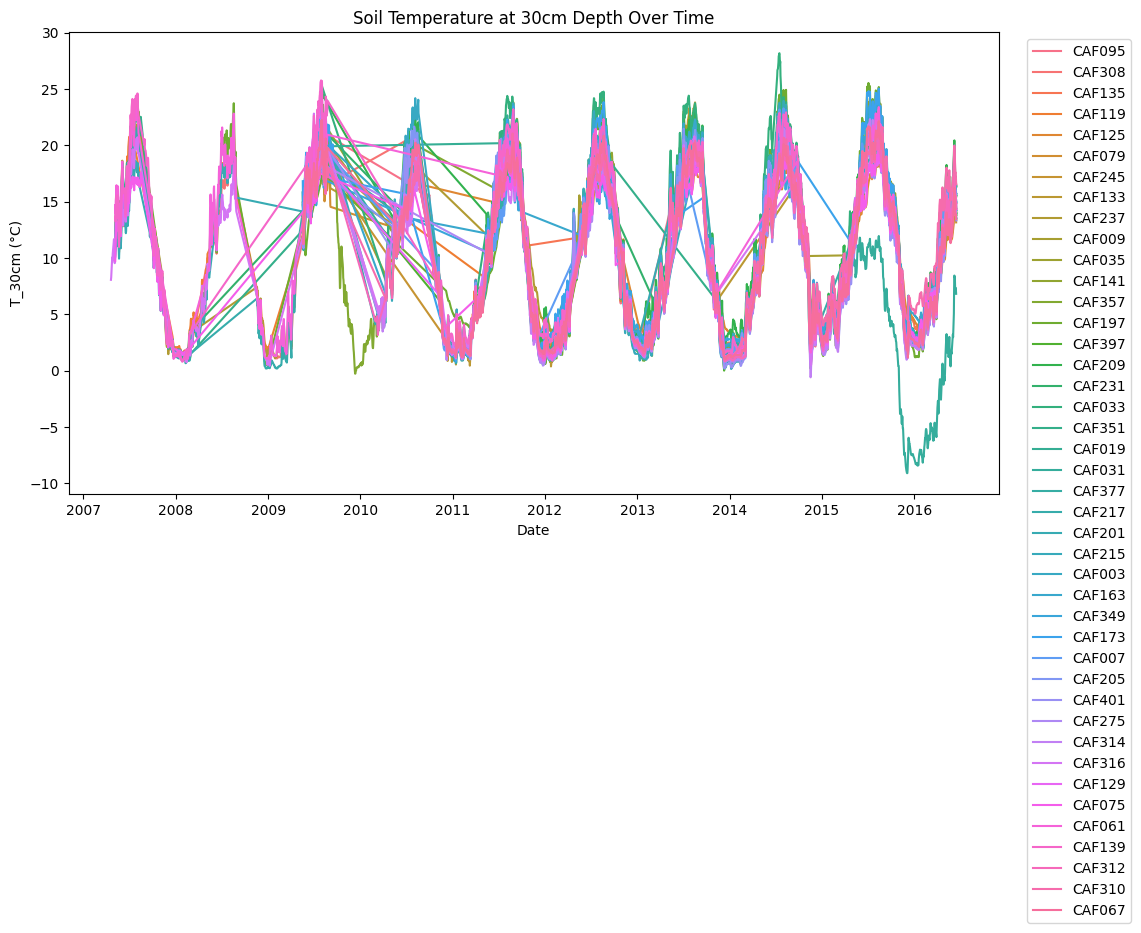

In [12]:
plot_temp_at_depth(daily_data, 30)

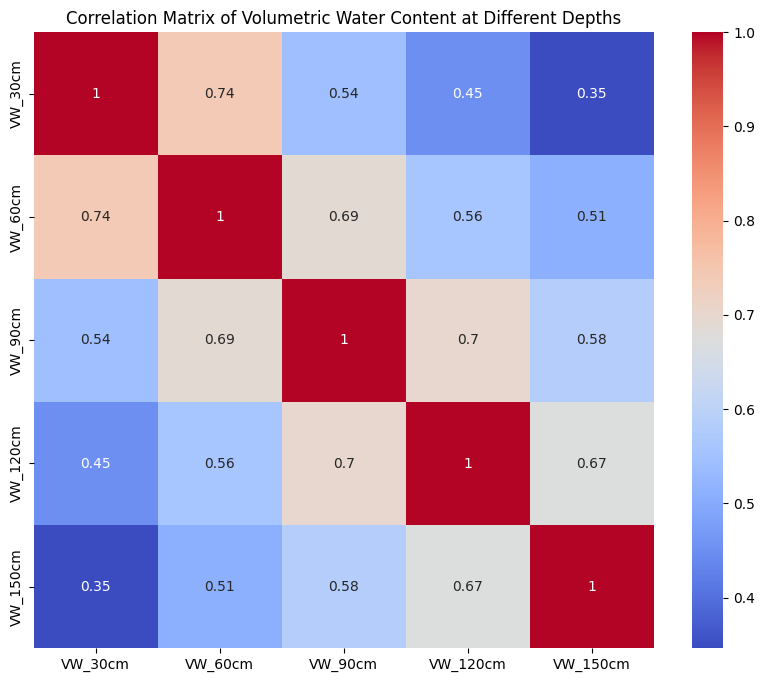

In [13]:

# Correlation: volumetric water content and temperature
correlation_vw = daily_data.filter(regex='^VW').corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_vw, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Volumetric Water Content at Different Depths')
plt.show()



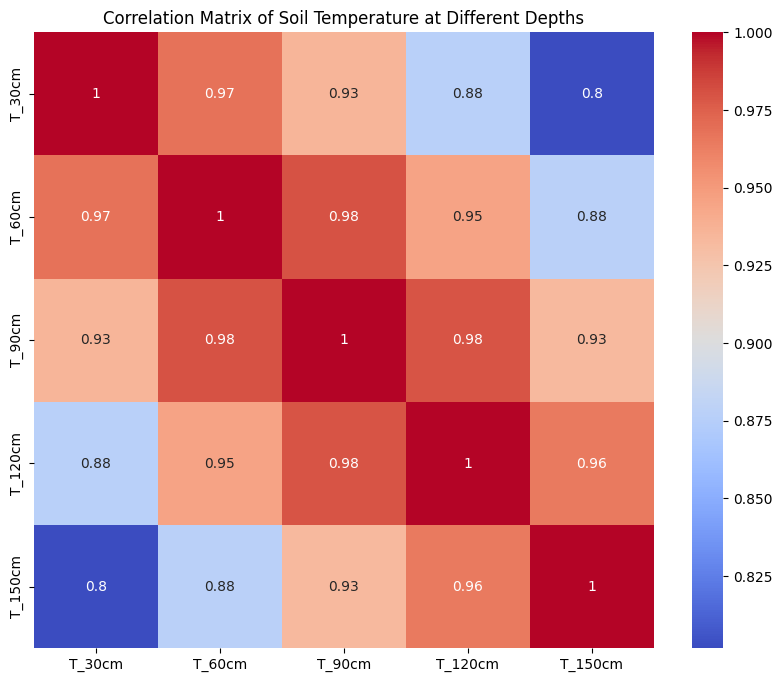

In [14]:
correlation_temp = daily_data.filter(regex='^T').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_temp, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Soil Temperature at Different Depths')
plt.show()


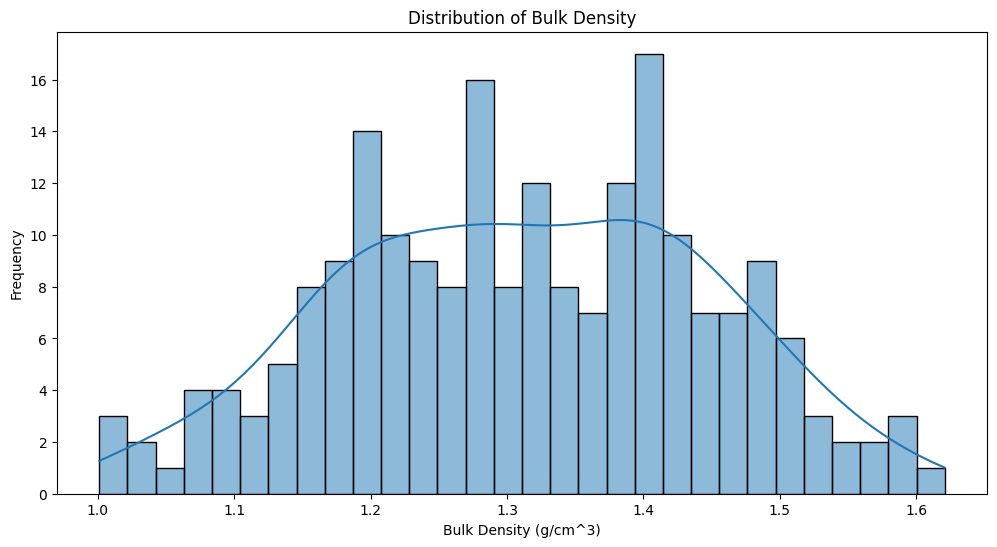

In [15]:
# Histograms of soil properties
plt.figure(figsize=(12, 6))
sns.histplot(bulk_density_data['BulkDensity'], bins=30, kde=True)
plt.title('Distribution of Bulk Density')
plt.xlabel('Bulk Density (g/cm^3)')
plt.ylabel('Frequency')
plt.show()


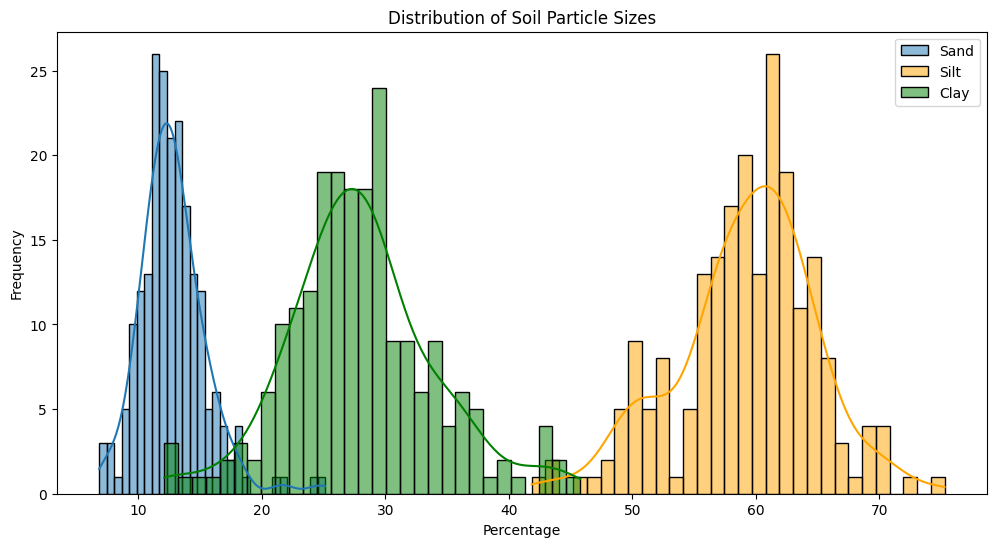

In [16]:

plt.figure(figsize=(12, 6))
sns.histplot(particle_size_data['Sand'], bins=30, kde=True, label='Sand')
sns.histplot(particle_size_data['Silt'], bins=30, kde=True, color='orange', label='Silt')
sns.histplot(particle_size_data['Clay'], bins=30, kde=True, color='green', label='Clay')
plt.title('Distribution of Soil Particle Sizes')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.show()